In [ ]:
pip install infomap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.8/264.8 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for infomap: filename=infomap-2.8.0-cp311-cp311-linux_x86_64.whl size=7698804 sha256=91183319a446537f8ecd6986e4ac1c8d56e925877baa60c1d66da9afe5b65920
  Stored in directory: /root/.cache/pip/wheels/f2/07/de/ee649642ec15485c0eaf89c9f06eb4f19a9b45e744e6808a8d
Successfully built infomap


In [ ]:

import pandas as pd
import networkx as nx

# Lee los archivos Excel

nodos = pd.read_excel('Base Limpia.xlsx')

nodos.columns

Index(['Organization Name', 'Headquarters Location', 'Operating Status',
       'Company Type', 'Number of Investments', 'Number of Lead Investments',
       'Number of Diversity Investments', 'Number of Exits',
       'Number of Lead Investors', 'Number of Investors', 'Industry Groups',
       'Industries', 'Number of Funding Rounds', 'Funding Status',
       'Last Funding Date', 'Last Funding Amount',
       'Last Funding Amount Currency', 'Last Funding Amount Currency (in USD)',
       'Last Funding Type', 'Last Equity Funding Type',
       'Last Equity Funding Amount', 'Last Equity Funding Amount Currency',
       'Last Equity Funding Amount Currency (in USD)', 'Total Funding Amount',
       'Total Funding Amount Currency',
       'Total Funding Amount Currency (in USD)', 'Number of Events',
       'SEMrush - Monthly Visits', 'SEMrush - Average Visits (6 months)',
       'SEMrush - Visit Duration', 'Principales inversionistas'],
      dtype='object')

In [ ]:
arcos = pd.read_excel('Arcos_filtrados.xlsx')

In [ ]:
# Crea un grafo dirigido
grafo = nx.DiGraph()

# Agrega los nodos al grafo
for indice, fila in nodos.iterrows():
  grafo.add_node(fila['Organization Name'], **fila.to_dict()) #Asume que 'ID' es la columna de identificacion de nodos


# Agrega los arcos al grafo
for indice, fila in arcos.iterrows():
  try:
    grafo.add_edge(fila['Source'], fila['Target'])
  except KeyError:
    print(f"Advertencia: Arco en la fila {indice+1} no pudo ser añadido, revisá que 'Source' y 'Target' existan en la tabla de arcos.")


# Imprime información básica del grafo (opcional)
print(f"Número de nodos: {grafo.number_of_nodes()}")
print(f"Número de arcos: {grafo.number_of_edges()}")




Número de nodos: 2078
Número de arcos: 4116


In [ ]:

# Verifica si el grafo está estrictamente conectado
es_estrictamente_conectado = nx.is_strongly_connected(grafo)
print(f"¿El grafo está estrictamente conectado?: {es_estrictamente_conectado}")

# Verifica si el grafo está conectado (sin considerar la dirección de los arcos)
es_conectado = nx.is_connected(grafo.to_undirected())
print(f"¿El grafo está conectado?: {es_conectado}")


¿El grafo está estrictamente conectado?: False
¿El grafo está conectado?: False


In [ ]:


# Para grafos dirigidos, usar componentes débilmente conectados
if nx.is_directed(grafo):
    componentes = list(nx.weakly_connected_components(grafo))
else:
    componentes = list(nx.connected_components(grafo))

# Seleccionar el componente más grande
largest_cc = max(componentes, key=len)

# Extraer el subgrafo correspondiente y hacer una copia real
largest_subgraph = grafo.subgraph(largest_cc).copy()

# Verificar cuántos nodos y aristas tiene
print(f"Subgrafo más grande: {largest_subgraph.number_of_nodes()} nodos, {largest_subgraph.number_of_edges()} aristas.")

# Asignar el subgrafo como el nuevo grafo
grafo = largest_subgraph



Subgrafo más grande: 2030 nodos, 4096 aristas.


In [ ]:
grafo.remove_edges_from(nx.selfloop_edges(grafo))


# Imprime información básica del grafo (opcional)
print(f"Número de nodos sin self loops: {grafo.number_of_nodes()}")
print(f"Número de arcos sin self loops: {grafo.number_of_edges()}")

Número de nodos sin self loops: 2030
Número de arcos sin self loops: 4089


In [ ]:
import networkx as nx
import numpy as np
import pandas as pd

def calcular_metricas_por_cluster(G, partitions):
    """
    Calcula métricas por cluster:
    - Cantidad de nodos por cluster.
    - Promedio del grado de los nodos en cada cluster.
    - Promedio de las variables de financiamiento en cada cluster.

    Parámetros:
    -----------
    G : networkx.Graph
        El grafo de NetworkX.
    partitions : list of sets
        Una lista de conjuntos, donde cada conjunto representa un cluster (comunidad).

    Retorna:
    --------
    pd.DataFrame
        Un DataFrame donde cada fila corresponde a un cluster y las columnas contienen
        las métricas calculadas.
    """
    metricas_por_cluster = []

    for i, cluster in enumerate(partitions):
        # Cantidad de nodos en el cluster
        cantidad_nodos = len(cluster)

        # Promedio del grado de los nodos en el cluster
        grados = [G.degree(nodo) for nodo in cluster]
        promedio_grado = sum(grados) / cantidad_nodos if cantidad_nodos > 0 else 0

        # Inicializar listas para las variables de financiamiento
        total_funding = []
        last_equity_funding = []
        last_funding = []

        for nodo in cluster:
            # Convertir y recolectar 'Total Funding Amount Currency'
            if 'Total Funding Amount Currency' in G.nodes[nodo]:
                try:
                    valor = float(G.nodes[nodo]['Total Funding Amount Currency'])
                    if not np.isnan(valor):  # Ignorar NaNs
                        total_funding.append(valor)
                except (ValueError, TypeError):
                    pass  # Ignorar valores no convertibles a float

            # Convertir y recolectar 'Last Equity Funding Amount Currency (in USD)'
            if 'Last Equity Funding Amount Currency (in USD)' in G.nodes[nodo]:
                try:
                    valor = float(G.nodes[nodo]['Last Equity Funding Amount Currency (in USD)'])
                    if not np.isnan(valor):  # Ignorar NaNs
                        last_equity_funding.append(valor)
                except (ValueError, TypeError):
                    pass  # Ignorar valores no convertibles a float

            # Convertir y recolectar 'Last Funding Amount Currency (in USD)'
            if 'Last Funding Amount Currency (in USD)' in G.nodes[nodo]:
                try:
                    valor = float(G.nodes[nodo]['Last Funding Amount Currency (in USD)'])
                    if not np.isnan(valor):  # Ignorar NaNs
                        last_funding.append(valor)
                except (ValueError, TypeError):
                    pass  # Ignorar valores no convertibles a float

        # Calcular promedios, ignorando listas vacías
        promedio_total_funding = np.mean(total_funding) if total_funding else 0
        promedio_last_equity_funding = np.mean(last_equity_funding) if last_equity_funding else 0
        promedio_last_funding = np.mean(last_funding) if last_funding else 0

        # Guardar las métricas en una lista de diccionarios
        metricas_por_cluster.append({
            'Cluster': i,
            'Cantidad_nodos': cantidad_nodos,
            'Promedio_grado': promedio_grado,
            'Promedio_Total_Funding': promedio_total_funding,
            'Promedio_Last_Equity_Funding': promedio_last_equity_funding,
            'Promedio_Last_Funding': promedio_last_funding
        })

    # Convertir la lista de diccionarios a un DataFrame
    df_metricas = pd.DataFrame(metricas_por_cluster)
    return df_metricas

# Greedy Modularity

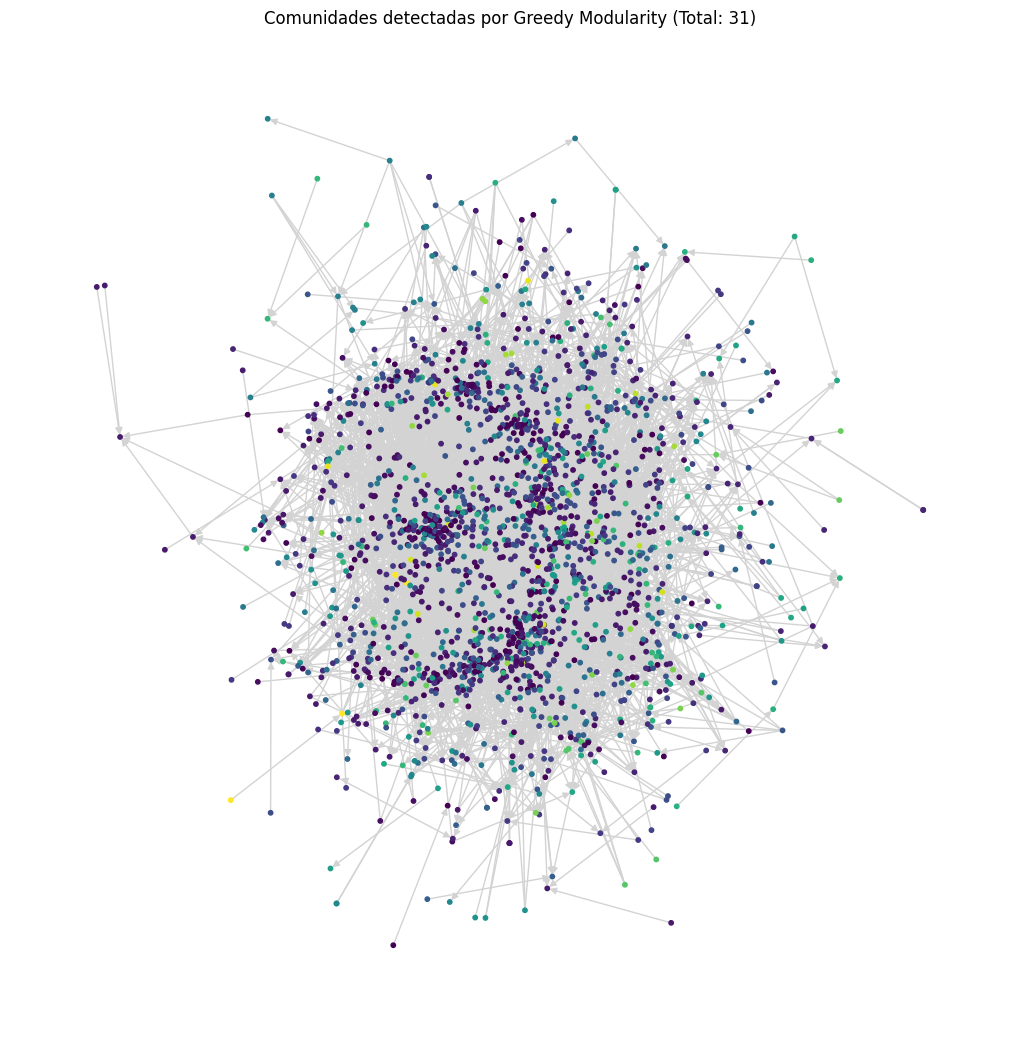

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
partitions = greedy_modularity_communities(grafo)
comxx=len(partitions)

nodos = list(grafo.nodes())
values = {node: 0 for node in nodos}

for i in nodos:
    for j in range(0,len(partitions)):
        if(i in list(partitions[j])):
            values[i] = j+1
values_list = list(values.values())
# Dimensionar gráfica
plt.figure(figsize=(10,10))


pos = nx.kamada_kawai_layout(grafo)
nx.draw(grafo, pos=pos, node_size=10, node_color=list(values.values()),edge_color='lightgray')
plt.title(f"Comunidades detectadas por Greedy Modularity (Total: {comxx})")
plt.show()

De la grafica anterior podemos observar que  se tienen 31 comunidades creadas lo que significa que hay comunidades o que realizan transacciones entre sí y que existe cierto grado de aislamiento entre las comunidades.

Comunidad 1: 233 nodos
Comunidad 2: 227 nodos
Comunidad 3: 211 nodos
Comunidad 4: 176 nodos
Comunidad 5: 129 nodos
Comunidad 6: 95 nodos
Comunidad 7: 93 nodos
Comunidad 8: 92 nodos
Comunidad 9: 77 nodos
Comunidad 10: 70 nodos
Comunidad 11: 65 nodos
Comunidad 12: 64 nodos
Comunidad 13: 62 nodos
Comunidad 14: 53 nodos
Comunidad 15: 52 nodos
Comunidad 16: 52 nodos
Comunidad 17: 41 nodos
Comunidad 18: 39 nodos
Comunidad 19: 39 nodos
Comunidad 20: 35 nodos
Comunidad 21: 33 nodos
Comunidad 22: 20 nodos
Comunidad 23: 11 nodos
Comunidad 24: 11 nodos
Comunidad 25: 9 nodos
Comunidad 26: 9 nodos
Comunidad 27: 9 nodos
Comunidad 28: 7 nodos
Comunidad 29: 6 nodos
Comunidad 30: 5 nodos
Comunidad 31: 5 nodos


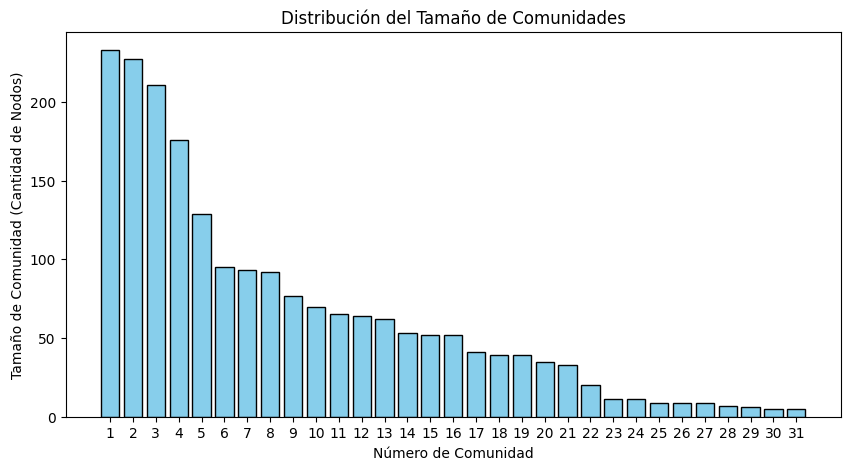

In [ ]:
# Asumiendo que ya tienes un grafo definido como 'grafo'
partitions = greedy_modularity_communities(grafo)

# Calcular el tamaño de cada comunidad
tamanos = [len(comunidad) for comunidad in partitions]

# Mostrar los tamaños de cada comunidad
for i, tam in enumerate(tamanos):
    print(f"Comunidad {i+1}: {tam} nodos")

# Graficar distribución de tamaños de comunidades
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(tamanos) + 1), tamanos, color='skyblue', edgecolor='black')
plt.xlabel("Número de Comunidad")
plt.ylabel("Tamaño de Comunidad (Cantidad de Nodos)")
plt.title("Distribución del Tamaño de Comunidades")
plt.xticks(range(1, len(tamanos) + 1))
plt.show()


Además, al analizar las comunidades podemos observar que no existe una distribución uniforme entre las comunidades.

In [ ]:

resultados_por_comunidad = {}

for i, comunidad in enumerate(partitions):
    subgrafo = grafo.subgraph(comunidad)

    # Calcular grado promedio
    grados = [grado for _, grado in subgrafo.degree()]
    grado_promedio = sum(grados) / len(grados) if grados else 0  # Evita divisiones por cero

    # Calcular densidad
    densidad = nx.density(subgrafo)  # Función de NetworkX para densidad

    # Guardar en el diccionario
    resultados_por_comunidad[f"Comunidad {i+1}"] = (densidad, grado_promedio)

# Mostrar resultados
for comunidad, (densidad, grado_promedio) in resultados_por_comunidad.items():
    print(f"{comunidad}: Densidad = {densidad:.4f}, Grado promedio = {grado_promedio:.2f}")


Comunidad 1: Densidad = 0.0091, Grado promedio = 4.24
Comunidad 2: Densidad = 0.0062, Grado promedio = 2.81
Comunidad 3: Densidad = 0.0073, Grado promedio = 3.08
Comunidad 4: Densidad = 0.0098, Grado promedio = 3.44
Comunidad 5: Densidad = 0.0092, Grado promedio = 2.36
Comunidad 6: Densidad = 0.0119, Grado promedio = 2.23
Comunidad 7: Densidad = 0.0122, Grado promedio = 2.24
Comunidad 8: Densidad = 0.0133, Grado promedio = 2.41
Comunidad 9: Densidad = 0.0135, Grado promedio = 2.05
Comunidad 10: Densidad = 0.0164, Grado promedio = 2.26
Comunidad 11: Densidad = 0.0159, Grado promedio = 2.03
Comunidad 12: Densidad = 0.0166, Grado promedio = 2.09
Comunidad 13: Densidad = 0.0175, Grado promedio = 2.13
Comunidad 14: Densidad = 0.0196, Grado promedio = 2.04
Comunidad 15: Densidad = 0.0200, Grado promedio = 2.04
Comunidad 16: Densidad = 0.0215, Grado promedio = 2.19
Comunidad 17: Densidad = 0.0244, Grado promedio = 1.95
Comunidad 18: Densidad = 0.0277, Grado promedio = 2.10
Comunidad 19: Densi

De la información analizada, se puede concluir que las comunidades con mayor grado son las comunidades 1 a 4, las cuales presentan un promedio de 4 a 3 conexiones por nodo, en comparación con otras comunidades que tienen un grado general de 1 o 2 conexiones. Además, se observa que las comunidades más pequeñas tienden a tener una densidad mayor, ya que hay menos nodos para conectar.

In [ ]:

from networkx.algorithms.community.quality import partition_quality
from networkx.algorithms.community.quality import modularity

cobertura, rendimiento = partition_quality(grafo, partitions)
modularidad = modularity(grafo, partitions)
print(f"Cobertura: {cobertura}")
print(f"Rendimiento: {rendimiento}")
print(f"Modularidad: {modularidad}")


Cobertura: 0.661286378087552
Rendimiento: 0.9368727345121356
Modularidad: 0.5692089095397042


In [ ]:
calcular_metricas_por_cluster(grafo, partitions)

,Cluster,Cantidad_nodos,Promedio_grado,Promedio_Total_Funding,Promedio_Last_Equity_Funding,Promedio_Last_Funding
0,0,233,6.695279,0,3.462630e+08,3.923480e+08
1,1,227,4.317181,0,1.388663e+08,1.466885e+08
2,2,211,4.800948,0,6.977729e+08,7.968320e+08
3,3,176,5.357955,0,1.629156e+08,1.858306e+08
4,4,129,3.945736,0,1.941565e+08,2.049549e+08
5,5,95,3.473684,0,1.952082e+08,1.832200e+08
6,6,93,3.419355,0,1.519940e+08,1.650003e+08
7,7,92,3.445652,0,1.084956e+08,1.142671e+08
8,8,77,3.000000,0,9.203333e+07,9.134852e+07
9,9,70,3.300000,0,1.958418e+08,2.474842e+08


# InfoMap

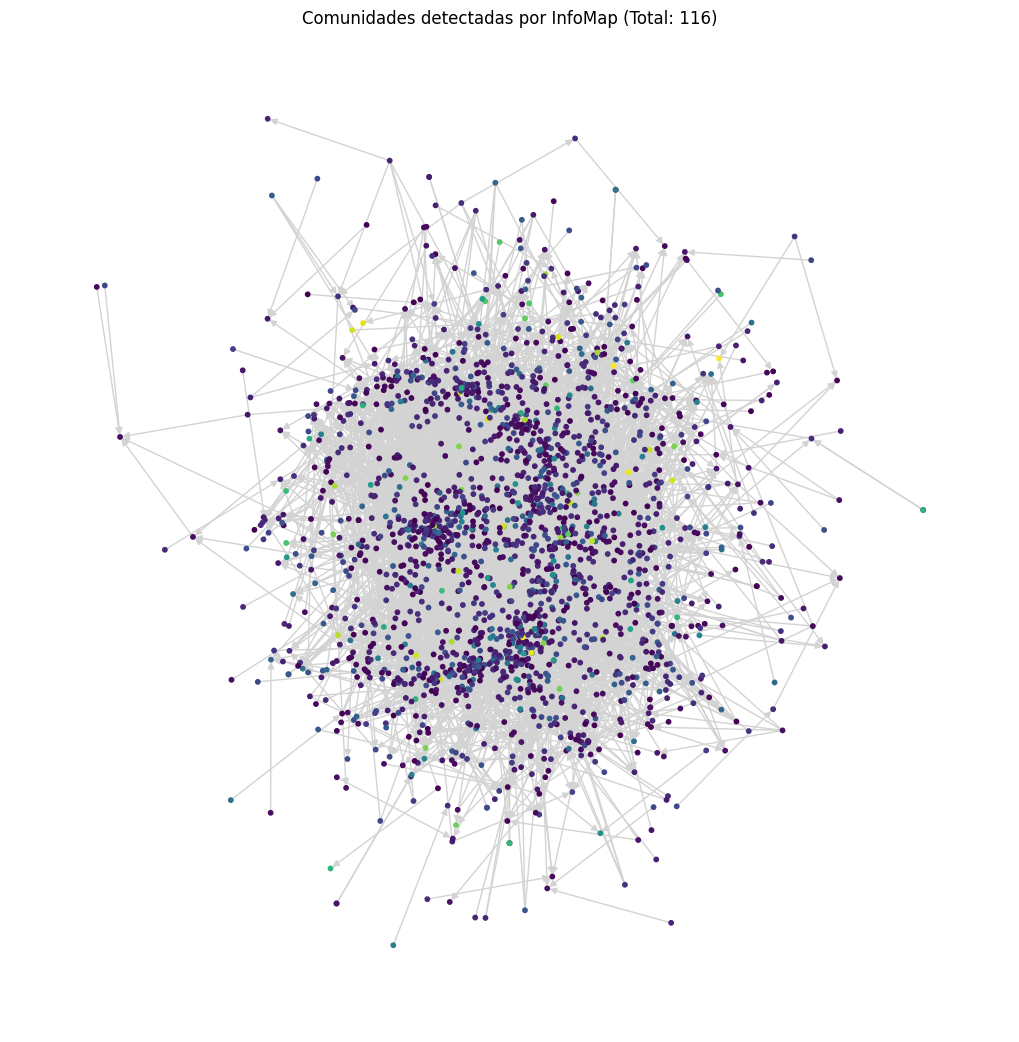

In [ ]:
from infomap import Infomap
node_map = {node: idx for idx, node in enumerate(set(n for edge in grafo.edges() for n in edge))}
im = Infomap(flow_model="directed")
for edge in grafo.edges():

    im.add_link(node_map[edge[0]], node_map[edge[1]])

im.run()

comInfo = len(set(im.get_modules().values()))
comInfo

info={}
for node in im.tree:
    if node.is_leaf:
        info[node.node_id]=node.module_id

# Ordenar diccionario
info = dict(sorted(info.items()))
len(info)
# Definir lienzo
fig=plt.figure(figsize=(10,10))

# Guardar posiciones
pos = nx.kamada_kawai_layout(grafo)

# Graficar
nx.draw(grafo, pos=pos, node_size=10, node_color=list(info.values()),edge_color='lightgray')

plt.title(f"Comunidades detectadas por InfoMap (Total: {comInfo})")
plt.show()

In [ ]:
from networkx.algorithms.community.quality import partition_quality, modularity

# 1. Get all nodes in the original graph
all_nodes = set(grafo.nodes())

# 2. Map nodes to communities based on Infomap output
comunidades_infomap = {}
for node in im.nodes:
    comunidades_infomap[node.node_id] = node.module_id

# 3. Add missing nodes to a separate community (e.g., community 0) or create singleton communities
for node in all_nodes:
    node_id = node_map.get(node)  # Get the node ID from node_map
    if node_id is not None and node_id not in comunidades_infomap:
        # Assign to community 0 (or create a new community for singletons)
        comunidades_infomap[node_id] = 0

# 4. Reconstruct partitions_infomap with updated information
partitions_infomap = []
comunidades_unicas = set(comunidades_infomap.values())
for com_id in comunidades_unicas:
    nodos_comunidad = {node for node, c in comunidades_infomap.items() if c == com_id}
    # Convert node IDs back to original node names using the inverse of node_map
    nodos_comunidad_names = {node for node_id in nodos_comunidad if (node := {v: k for k, v in node_map.items()}.get(node_id))}
    partitions_infomap.append(nodos_comunidad_names)

# Now you can calculate coverage, performance, and modularity:
cobertura, rendimiento = partition_quality(grafo, partitions_infomap)
modularidad = modularity(grafo, partitions_infomap)

# Display the results:
print(f"Cobertura: {cobertura}")
print(f"Rendimiento: {rendimiento}")
print(f"Modularidad: {modularidad}")


Cobertura: 0.5008559550012228
Rendimiento: 0.968283291291058
Modularidad: 0.47386509780757935


In [ ]:
calcular_metricas_por_cluster(grafo, partitions_infomap)

,Cluster,Cantidad_nodos,Promedio_grado,Promedio_Total_Funding,Promedio_Last_Equity_Funding,Promedio_Last_Funding
0,0,105,4.180952,0,2.265952e+08,2.522261e+08
1,1,117,3.555556,0,4.543915e+08,4.708462e+08
2,2,122,3.360656,0,1.433967e+08,1.391847e+08
3,3,98,4.163265,0,5.094769e+08,1.395924e+08
4,4,73,4.068493,0,4.578678e+08,4.232247e+08
...,...,...,...,...,...,...
111,111,1,11.000000,0,0.000000e+00,0.000000e+00
112,112,1,11.000000,0,0.000000e+00,0.000000e+00
113,113,1,4.000000,0,0.000000e+00,8.000000e+07
114,114,1,19.000000,0,0.000000e+00,0.000000e+00


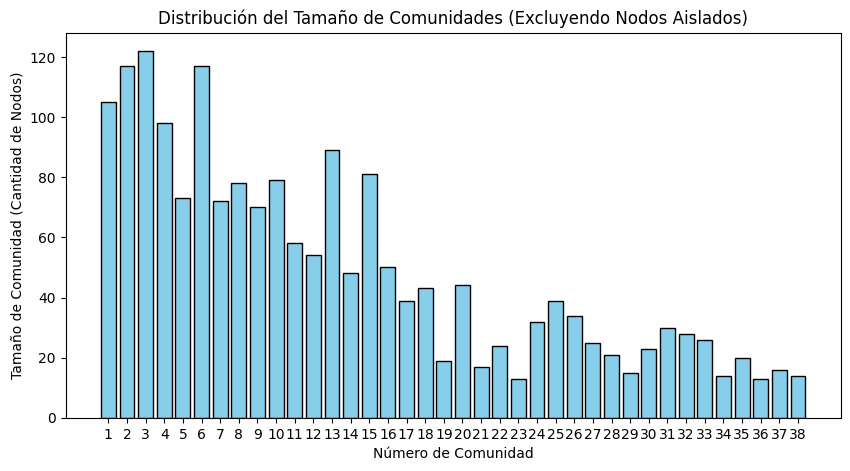

In [ ]:
from infomap import Infomap
import networkx as nx
import matplotlib.pyplot as plt

# Crear un mapeo de nodos a índices únicos
node_map = {node: idx for idx, node in enumerate(set(n for edge in grafo.edges() for n in edge))}
im = Infomap(flow_model="directed")

# Agregar enlaces al modelo Infomap
for edge in grafo.edges():
    im.add_link(node_map[edge[0]], node_map[edge[1]])

# Ejecutar Infomap
im.run()

# Obtener los módulos detectados
info = {}
for node in im.tree:
    if node.is_leaf:
        info[node.node_id] = node.module_id

# Contar el tamaño de cada comunidad
comunidades = {}
for nodo, comunidad in info.items():
    if comunidad not in comunidades:
        comunidades[comunidad] = []
    comunidades[comunidad].append(nodo)

# Filtrar comunidades con más de un nodo
comunidades_filtradas = {k: v for k, v in comunidades.items() if len(v) > 10}

# Calcular tamaños de comunidades restantes
tamanos = [len(nodos) for nodos in comunidades_filtradas.values()]

# Graficar distribución del tamaño de comunidades
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(tamanos) + 1), tamanos, color='skyblue', edgecolor='black')
plt.xlabel("Número de Comunidad")
plt.ylabel("Tamaño de Comunidad (Cantidad de Nodos)")
plt.title("Distribución del Tamaño de Comunidades (Excluyendo Nodos Aislados)")
plt.xticks(range(1, len(tamanos) + 1))
plt.show()


Como se mostró anteriormente, las comunidades no tienen una distribución uniforme. Además, algunas comunidades están más apartadas, ya que existen comunidades que se formaron con un solo nodo.

# Girvan Newman

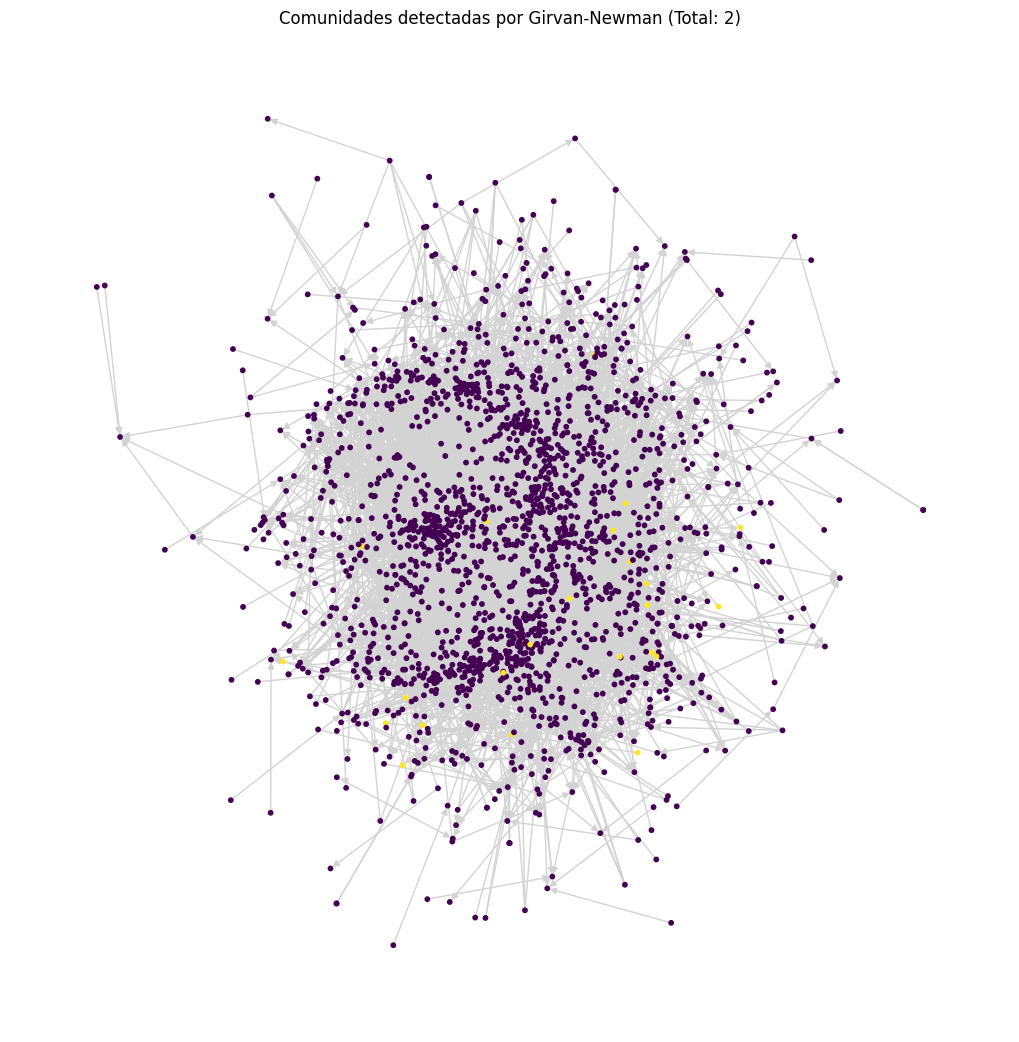

In [ ]:
from networkx.algorithms.community import girvan_newman

# Aplicar el algoritmo de Girvan-Newman
communities_gn = girvan_newman(grafo)

partitions_gn = tuple(sorted(c) for c in next(communities_gn))

comGN = len(partitions_gn)

values_gn = {node: 0 for node in grafo.nodes()}
for i, community in enumerate(partitions_gn):
    for node in community:
        values_gn[node] = i + 1

# Convertir los valores a una lista para la gráfica
values_gn_list = list(values_gn.values())

# Dimensionar gráfica
plt.figure(figsize=(10, 10))

pos = nx.kamada_kawai_layout(grafo)
nx.draw(grafo, pos=pos, node_size=10, node_color=list(values_gn.values()),edge_color='lightgray')
plt.title(f"Comunidades detectadas por Girvan-Newman (Total: {comGN})")
plt.show()

In [ ]:

cobertura, rendimiento = partition_quality(grafo, partitions_gn)
modularidad = modularity(grafo, partitions_gn)
print(f"Cobertura: {cobertura}")
print(f"Rendimiento: {rendimiento}")
print(f"Modularidad: {modularidad}")


Cobertura: 0.9990217657128883
Rendimiento: 0.025330005559777317
Modularidad: 0.011658069437050535


In [ ]:
calcular_metricas_por_cluster(grafo, partitions_gn)

,Cluster,Cantidad_nodos,Promedio_grado,Promedio_Total_Funding,Promedio_Last_Equity_Funding,Promedio_Last_Funding
0,0,2005,4.052868,0,2.830389e+08,3.053783e+08
1,1,25,2.080000,0,8.323310e+07,1.183444e+08


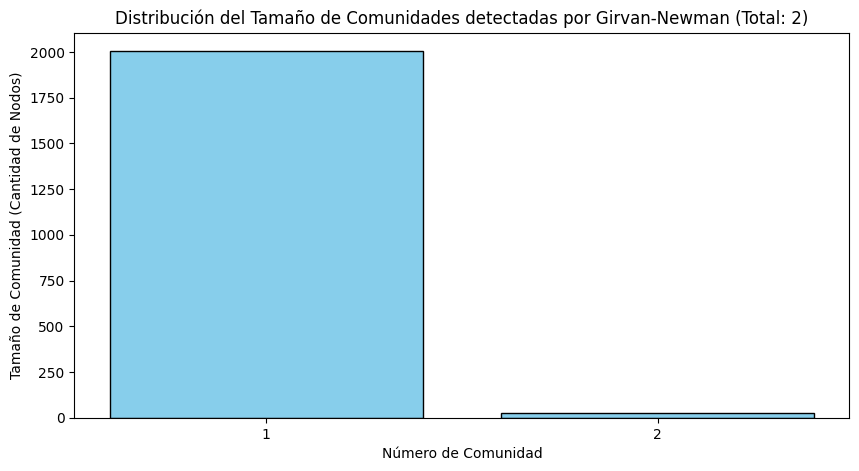

In [ ]:
communities_gn = girvan_newman(grafo)

# Obtener la primera partición (comunidades detectadas)
partitions_gn = tuple(sorted(c) for c in next(communities_gn))

# Calcular el tamaño de cada comunidad
tamanos_gn = [len(community) for community in partitions_gn]

# Graficar distribución del tamaño de comunidades
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(tamanos_gn) + 1), tamanos_gn, color='skyblue', edgecolor='black')
plt.xlabel("Número de Comunidad")
plt.ylabel("Tamaño de Comunidad (Cantidad de Nodos)")
plt.title(f"Distribución del Tamaño de Comunidades detectadas por Girvan-Newman (Total: {len(partitions_gn)})")
plt.xticks(range(1, len(tamanos_gn) + 1))
plt.show()


De la distribución de las comunidades del algoritmo anterior, se puede observar que no fue uniforme. La comunidad 1 concentra la mayoría de los nodos, mientras que la comunidad 2, en comparación, tiene un número significativamente menor.

**Análisis de cada método:**

1. **Girvan-Newman (2 comunidades)**
Cobertura: 0.9990 (muy alta, casi perfecta), Rendimiento: 0.0253 (muy bajo, indica que la partición no es muy eficiente), Modularidad: 0.0117 (extremadamente baja, sugiere que las comunidades no están bien definidas)

    **Conclusión:** Aunque la cobertura es excelente, lo que indica que casi todos los nodos en la red están bien cubiertos, el rendimiento y la modularidad son muy bajos. La partición en solo dos comunidades no refleja adecuadamente la estructura real de la red, lo que hace que esta opción no sea ideal para entender de manera precisa cómo están organizadas las organizaciones y sus conexiones.

2. **Infomap (78 comunidades)**
Cobertura: 0.5767 (moderada, no es la mejor), Rendimiento: 0.4489 (alto, indica una buena calidad de partición), Modularidad: 0.1853 (superior a Girvan-Newman, pero aún no es óptima)

    **Conclusión:** Infomap detecta muchas comunidades, lo que puede ser útil en algunos contextos en contextos donde se necesita una segmentación más detallada. Sin embargo, la cobertura moderada sugiere que parte de la red podría no estar siendo bien representada, lo que puede resultar en una pérdida de información clave. Esto podría generar desafíos al momento de tomar decisiones estratégicas sobre con qué organizaciones relacionarse, ya que podría ser difícil interpretar la relevancia de las comunidades detectadas.

3. **Greedy Modularity (31 comunidades)**
Cobertura: 0.6613 (la segunda mejor después de Girvan-Newman), Rendimiento: 0.9369 (el más alto, lo que indica que la partición es muy eficiente), Modularidad: 0.5692 (la mejor de las tres, lo que sugiere que las comunidades son bien definidas)

    **Conclusión:** Greedy Modularity es el método más equilibrado y eficiente, logrando una segmentación precisa y útil con 31 comunidades. La modularidad es considerablemente alta, lo que significa que las comunidades están bien diferenciadas, lo que facilita la identificación de grupos de organizaciones con intereses o características comunes. Además, el alto rendimiento de la partición indica que las comunidades son relevantes y bien estructuradas.


**Modelo Seleccionado:**

Greedy Modularity es el mejor modelo para nuestra organización, ya que ofrece un equilibrio adecuado entre la cantidad de comunidades, la cobertura, el rendimiento (0.9369) y la modularidad (0.5692). Con 31 comunidades bien definidas, es posible identificar segmentos relevantes de organizaciones en la red, lo cual es crucial para establecer relaciones estratégicas con aquellas que compartan intereses comunes y que puedan ser aliadas clave en nuestra búsqueda de financiación.

**Recomendaciones**

Para una organización que busca obtener financiación, es crucial identificar las comunidades clave dentro de la red. Se recomienda enfocarse en aquellas comunidades con alta modularidad, ya que las organzaciones dentro de ellas tienen relaciones más fuertes o tengan un enfoque similar. Además, es importante explorar los atributos comunes de las organizaciones como la industria a la que pertenecen, los recursos y otros factores relevantes.  
